In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
import librosa

In [ ]:
DATA_PATH = "/content/drive/MyDrive/data.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 57282 (223.76 KB)
Trainable params: 57282 (223.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
12/12 [

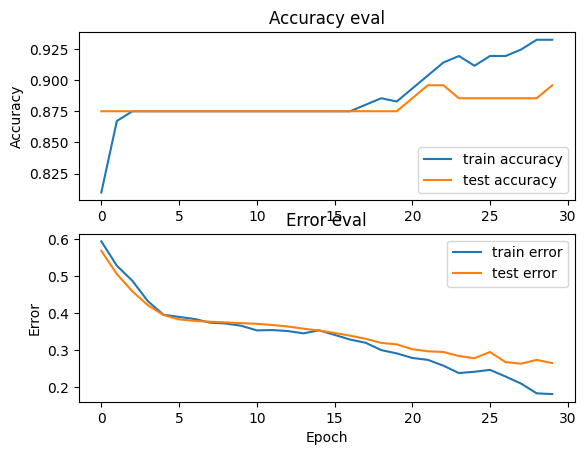

5/5 - 0s - loss: 0.2334 - accuracy: 0.9187 - 57ms/epoch - 11ms/step

Test accuracy: 0.918749988079071


In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [ ]:
model.save("/content/drive/MyDrive/audio_lstm.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
SAMPLE_RATE = 22050

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
def predict_genre(model, audio_file_path, genre_mapping):
    """Predicts the genre of an audio file using a trained model.

    Args:
        model: Trained genre classification model.
        audio_file_path: Path to the audio file.
        genre_mapping: Dictionary mapping class indices to genre labels.

    Returns:
        Predicted genre label.
    """

    # Load audio file
    signal, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Reshape MFCCs to match model input shape
    mfcc = mfcc[:130, ...]  # Take only the first 130 MFCCs
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Add extra dimensions


    # Predict using the model
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)

    # Map predicted index to genre label
    genre_label = genre_mapping[predicted_index[0]]
    print("Raw prediction:", prediction)

    return genre_label

# Load your trained model
model_path = "/content/drive/MyDrive/audio_lstm.h5"
model = load_model(model_path)

# Path to the audio file you want to predict
audio_file_path = "/content/my_voice.wav"

# Genre mapping (update this according to your dataset)
genre_mapping = {0: "real", 1: "fake"}

# Make the prediction
predicted_genre = predict_genre(model, audio_file_path, genre_mapping)

print("Predicted genre:", predicted_genre)

<ipython-input-13-584600505675>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(audio_file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 1s 595ms/step
Raw prediction: [[0.09923967 0.90076035]]
Predicted genre: fake
